# Task 2: Time Series Forecasting Models
## GMF Investments - Portfolio Optimization

**Objective:** Develop, train, and evaluate time series forecasting models to predict Tesla's future stock prices.

**Models to Implement:**
1. **ARIMA/SARIMA** - Classical statistical time series model
2. **LSTM** - Deep learning approach for sequence prediction

**Target Asset:** TSLA (Tesla) - High-growth stock with significant volatility

---

### Key Considerations:
- ⚠️ **Temporal Order:** Must split data chronologically (no random shuffling!)
- 📊 **Train Period:** 2015-2024
- 🔮 **Test Period:** 2025-2026
- 📈 **Evaluation Metrics:** MAE, RMSE, MAPE

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Libraries imported successfully!
TensorFlow version: 2.18.0
Keras version: 3.7.0


## 1. Load Processed Data from Task 1

In [5]:
# Load processed TSLA data from Task 1
try:
    # Read CSV with skiprows to handle the unusual format from yfinance
    # The CSV has 'Ticker' and 'Date' as extra rows at positions 1 and 2
    tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', 
                            skiprows=[1, 2],  # Skip 'Ticker' and 'Date' rows
                            index_col=0)       # First column is the date
    
    # Convert index to datetime
    tsla_data.index = pd.to_datetime(tsla_data.index)
    tsla_data.index.name = 'Date'
    
    # Remove 'Price' column if it exists (duplicate of Close)
    if 'Price' in tsla_data.columns:
        tsla_data = tsla_data.drop('Price', axis=1)
    
    print("✓ Loaded processed TSLA data from Task 1")
    
except FileNotFoundError:
    print("⚠️ Processed data not found. Downloading from YFinance...")
    import yfinance as yf
    tsla_data = yf.download('TSLA', start='2015-01-01', end='2026-01-15', progress=False)
    if isinstance(tsla_data.columns, pd.MultiIndex):
        tsla_data.columns = tsla_data.columns.droplevel(1)
    tsla_data['Daily_Return'] = tsla_data['Close'].pct_change() * 100

except Exception as e:
    print(f"⚠️ Error loading processed data: {e}")
    print("Downloading fresh data from YFinance...")
    import yfinance as yf
    tsla_data = yf.download('TSLA', start='2015-01-01', end='2026-01-15', progress=False)
    if isinstance(tsla_data.columns, pd.MultiIndex):
        tsla_data.columns = tsla_data.columns.droplevel(1)
    tsla_data['Daily_Return'] = tsla_data['Close'].pct_change() * 100

# Ensure data is sorted by date
tsla_data = tsla_data.sort_index()

print(f"\nDataset shape: {tsla_data.shape}")
print(f"Date range: {tsla_data.index[0].date()} to {tsla_data.index[-1].date()}")
print(f"\nColumns: {tsla_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(tsla_data.head())
print(f"\nLast few rows:")
print(tsla_data.tail())

✓ Loaded processed TSLA data from Task 1

Dataset shape: (2775, 6)
Date range: 2015-01-02 to 2026-01-14

Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return']

First few rows:
             Close    High     Low    Open    Volume  Daily_Return
Date                                                              
2015-01-02 14.6207 14.8833 14.2173 14.8580  71466000           NaN
2015-01-05 14.0060 14.4333 13.8107 14.3033  80527500       -4.2041
2015-01-06 14.0853 14.2800 13.6140 14.0040  93928500        0.5664
2015-01-07 14.0633 14.3187 13.9853 14.2233  44526000       -0.1562
2015-01-08 14.0413 14.2533 14.0007 14.1873  51637500       -0.1564

Last few rows:
              Close     High      Low     Open    Volume  Daily_Return
Date                                                                  
2026-01-08 435.8000 436.8900 424.3700 427.8900  57041100        1.0176
2026-01-09 445.0100 449.0500 430.3900 435.9500  67331500        2.1134
2026-01-12 448.9600 454.3000 438.0000 441

## 2. Prepare Data for Modeling - Train/Test Split

**Critical:** Time series data must be split chronologically to preserve temporal order!

TRAIN/TEST SPLIT

Train Period: 2015-01-02 to 2024-12-31
Train Size: 2516 days

Test Period: 2025-01-02 to 2026-01-14
Test Size: 259 days

Train/Test Ratio: 90.7% / 9.3%


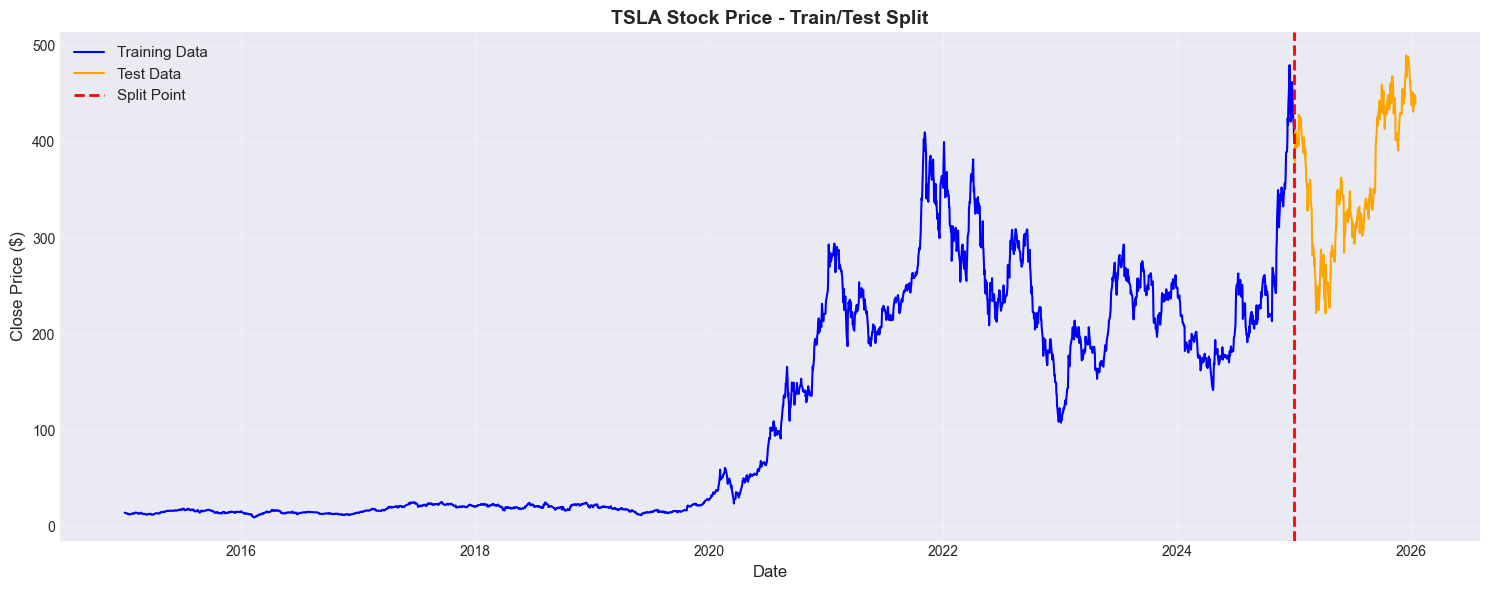

In [6]:
# Extract closing prices
close_prices = tsla_data['Close'].copy()
if isinstance(close_prices, pd.DataFrame):
    close_prices = close_prices.iloc[:, 0]

# Define split date (end of 2024)
split_date = '2024-12-31'

# Split data chronologically
train_data = close_prices[close_prices.index <= split_date]
test_data = close_prices[close_prices.index > split_date]

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"\nTrain Period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Train Size: {len(train_data)} days")
print(f"\nTest Period: {test_data.index[0].date()} to {test_data.index[-1].date()}")
print(f"Test Size: {len(test_data)} days")
print(f"\nTrain/Test Ratio: {len(train_data)/(len(train_data)+len(test_data))*100:.1f}% / {len(test_data)/(len(train_data)+len(test_data))*100:.1f}%")

# Visualize the split
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(train_data.index, train_data, label='Training Data', color='blue', linewidth=1.5)
ax.plot(test_data.index, test_data, label='Test Data', color='orange', linewidth=1.5)
ax.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', linewidth=2, label='Split Point')
ax.set_title('TSLA Stock Price - Train/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. ARIMA/SARIMA Model Implementation

### 3.1 ACF and PACF Analysis

In [7]:
# Check stationarity of training data
def check_stationarity(series, name="Series"):
    """Perform ADF test to check stationarity"""
    result = adfuller(series.dropna())
    print(f"\n{name} - ADF Test Results:")
    print(f"  ADF Statistic: {result[0]:.6f}")
    print(f"  p-value: {result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.3f}")
    
    if result[1] < 0.05:
        print(f"  ✓ Series is STATIONARY (p < 0.05)")
        return True
    else:
        print(f"  ✗ Series is NON-STATIONARY (p >= 0.05) - Differencing needed")
        return False

# Test original series
is_stationary = check_stationarity(train_data, "TSLA Close Price")

# If not stationary, apply first differencing
if not is_stationary:
    train_diff = train_data.diff().dropna()
    check_stationarity(train_diff, "TSLA Close Price (1st Difference)")


TSLA Close Price - ADF Test Results:
  ADF Statistic: -0.581403
  p-value: 0.875129
  Critical Values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  ✗ Series is NON-STATIONARY (p >= 0.05) - Differencing needed

TSLA Close Price (1st Difference) - ADF Test Results:
  ADF Statistic: -9.736259
  p-value: 0.000000
  Critical Values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  ✓ Series is STATIONARY (p < 0.05)


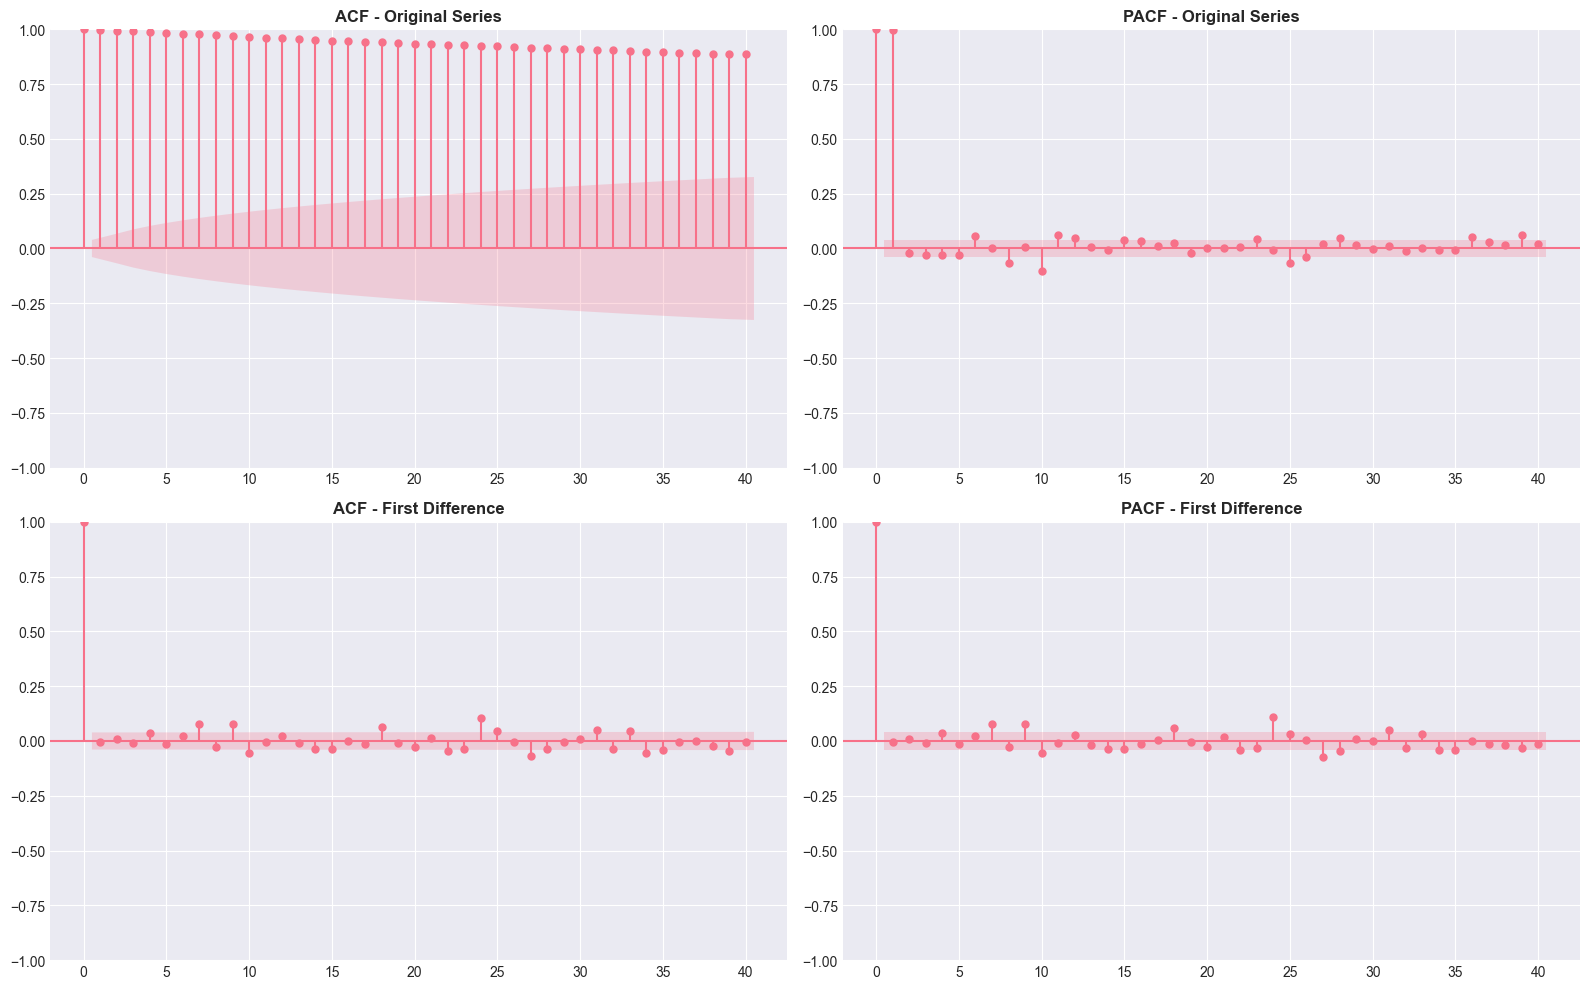


ACF/PACF INTERPRETATION GUIDE:

ACF (Autocorrelation Function):
- Shows correlation between observations at different lags
- Slow decay → Non-stationary, needs differencing
- Sharp cutoff at lag q → MA(q) component

PACF (Partial Autocorrelation Function):
- Shows direct correlation at specific lags
- Sharp cutoff at lag p → AR(p) component

For ARIMA(p,d,q):
- p = AR order (from PACF cutoff)
- d = Differencing order (usually 1 or 2)
- q = MA order (from ACF cutoff)



In [8]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Original series
plot_acf(train_data.dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original Series', fontsize=12, fontweight='bold')

plot_pacf(train_data.dropna(), lags=40, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF - Original Series', fontsize=12, fontweight='bold')

# First differenced series
train_diff = train_data.diff().dropna()
plot_acf(train_diff, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - First Difference', fontsize=12, fontweight='bold')

plot_pacf(train_diff, lags=40, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF - First Difference', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ACF/PACF INTERPRETATION GUIDE:")
print("="*60)
print("""
ACF (Autocorrelation Function):
- Shows correlation between observations at different lags
- Slow decay → Non-stationary, needs differencing
- Sharp cutoff at lag q → MA(q) component

PACF (Partial Autocorrelation Function):
- Shows direct correlation at specific lags
- Sharp cutoff at lag p → AR(p) component

For ARIMA(p,d,q):
- p = AR order (from PACF cutoff)
- d = Differencing order (usually 1 or 2)
- q = MA order (from ACF cutoff)
""")

### 3.2 Auto ARIMA - Automatic Parameter Selection

In [9]:
print("Finding optimal ARIMA parameters using auto_arima...")
print("This may take a few minutes...\n")

# Use auto_arima to find best parameters
auto_model = auto_arima(
    train_data,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,  # Let auto_arima determine d
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    n_jobs=-1
)

print("\n" + "="*60)
print("AUTO ARIMA RESULTS")
print("="*60)
print(auto_model.summary())

Finding optimal ARIMA parameters using auto_arima...
This may take a few minutes...

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16368.573, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16370.458, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16370.460, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16368.109, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16372.458, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.694 seconds

AUTO ARIMA RESULTS
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8183.054
Date:                Tue, 27 Jan 2026   AIC                          16368.109
Time:                        21:51:33   BIC                          16373.939
Sample:                             0   HQIC 

### 3.3 Fit ARIMA Model and Generate Forecasts

In [10]:
# Extract best parameters
best_order = auto_model.order
print(f"\nBest ARIMA Order: {best_order}")
print(f"  p (AR order): {best_order[0]}")
print(f"  d (Differencing): {best_order[1]}")
print(f"  q (MA order): {best_order[2]}")

# Fit ARIMA model
arima_model = ARIMA(train_data, order=best_order)
arima_fitted = arima_model.fit()

print("\n" + "="*60)
print("ARIMA MODEL SUMMARY")
print("="*60)
print(arima_fitted.summary())

# Generate forecasts for test period
n_periods = len(test_data)
print(f"\nGenerating {n_periods} forecasts...")

# Use get_forecast for better control
forecast_object = arima_fitted.get_forecast(steps=n_periods)
arima_forecast = forecast_object.predicted_mean

# Verify forecast values
print(f"Forecast type: {type(arima_forecast)}")
print(f"Forecast shape: {arima_forecast.shape}")
print(f"First 3 forecast values: {arima_forecast[:3]}")
print(f"Contains NaN: {arima_forecast.isna().any() if hasattr(arima_forecast, 'isna') else np.isnan(arima_forecast).any()}")

# Create forecast series with correct index
arima_predictions = pd.Series(arima_forecast.values if hasattr(arima_forecast, 'values') else arima_forecast, 
                               index=test_data.index)

print(f"\n✓ Generated {n_periods} forecasts for test period")
print(f"  Forecast range: {arima_predictions.index[0].date()} to {arima_predictions.index[-1].date()}")
print(f"  Forecast values range: ${arima_predictions.min():.2f} to ${arima_predictions.max():.2f}")
print(f"  NaN count: {arima_predictions.isna().sum()}")


Best ARIMA Order: (0, 1, 0)
  p (AR order): 0
  d (Differencing): 1
  q (MA order): 0

ARIMA MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8183.054
Date:                Tue, 27 Jan 2026   AIC                          16368.109
Time:                        21:51:38   BIC                          16373.939
Sample:                             0   HQIC                         16370.225
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.2337      0.442     88.858      0.000      38.368      40.099
Ljung-Box (L1) (Q):    

c:\Users\nesre\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nesre\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nesre\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nesre\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

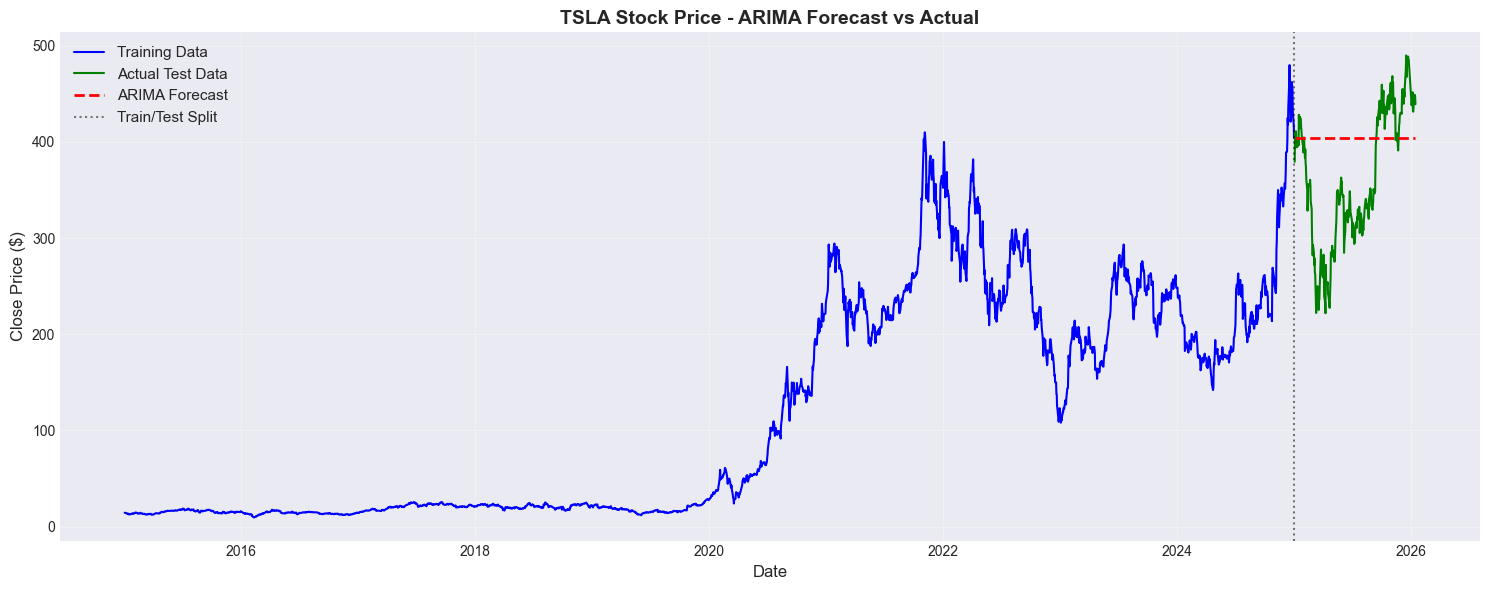

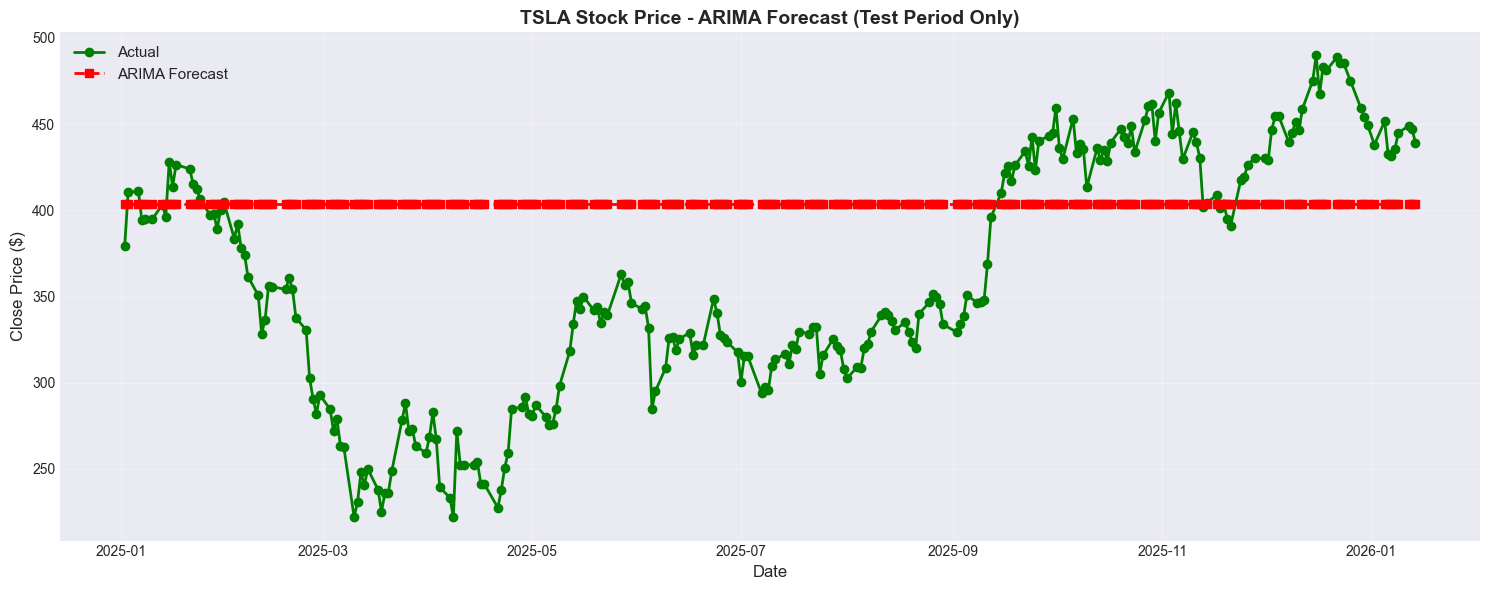

In [11]:
# Visualize ARIMA forecasts
fig, ax = plt.subplots(figsize=(15, 6))

# Plot training data
ax.plot(train_data.index, train_data, label='Training Data', color='blue', linewidth=1.5)

# Plot actual test data
ax.plot(test_data.index, test_data, label='Actual Test Data', color='green', linewidth=1.5)

# Plot ARIMA predictions
ax.plot(arima_predictions.index, arima_predictions, label='ARIMA Forecast', 
        color='red', linewidth=2, linestyle='--')

ax.axvline(x=pd.to_datetime(split_date), color='black', linestyle=':', linewidth=1.5, 
           alpha=0.5, label='Train/Test Split')
ax.set_title('TSLA Stock Price - ARIMA Forecast vs Actual', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Zoom in on test period
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(test_data.index, test_data, label='Actual', color='green', linewidth=2, marker='o')
ax.plot(arima_predictions.index, arima_predictions, label='ARIMA Forecast', 
        color='red', linewidth=2, linestyle='--', marker='s')
ax.set_title('TSLA Stock Price - ARIMA Forecast (Test Period Only)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. LSTM Model Implementation

### 4.1 Prepare Sequence Data for LSTM

In [12]:
def create_sequences(data, window_size):
    """
    Create sequences for LSTM training
    
    Parameters:
    -----------
    data : array-like
        Time series data
    window_size : int
        Number of time steps to use for prediction
        
    Returns:
    --------
    X : array
        Input sequences
    y : array
        Target values
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size (use last 60 days to predict next day)
WINDOW_SIZE = 60

print("="*60)
print("LSTM DATA PREPARATION")
print("="*60)
print(f"\nWindow Size: {WINDOW_SIZE} days")
print(f"Strategy: Use last {WINDOW_SIZE} days to predict next day\n")

# Scale the data (LSTM performs better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

print(f"✓ Data scaled to range [0, 1]")
print(f"  Original train range: ${train_data.min():.2f} - ${train_data.max():.2f}")
print(f"  Scaled train range: {train_scaled.min():.4f} - {train_scaled.max():.4f}")

# Create sequences
X_train, y_train = create_sequences(train_scaled.flatten(), WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled.flatten(), WINDOW_SIZE)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\n✓ Sequences created")
print(f"  X_train shape: {X_train.shape} (samples, time steps, features)")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

LSTM DATA PREPARATION

Window Size: 60 days
Strategy: Use last 60 days to predict next day

✓ Data scaled to range [0, 1]
  Original train range: $9.58 - $479.86
  Scaled train range: 0.0000 - 1.0000

✓ Sequences created
  X_train shape: (2456, 60, 1) (samples, time steps, features)
  y_train shape: (2456,)
  X_test shape: (199, 60, 1)
  y_test shape: (199,)


### 4.2 Build LSTM Architecture

In [13]:
# Build LSTM model
print("="*60)
print("LSTM MODEL ARCHITECTURE")
print("="*60)

lstm_model = Sequential([
    # First LSTM layer with dropout
    LSTM(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    
    # Second LSTM layer with dropout
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    # Third LSTM layer with dropout
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    # Dense layers
    Dense(units=25),
    Dense(units=1)
])

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

# Print model summary
print(lstm_model.summary())

# Count parameters
total_params = lstm_model.count_params()
print(f"\n✓ Model compiled successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Optimizer: Adam")
print(f"  Loss function: Mean Squared Error")
print(f"  Metrics: MAE")

LSTM MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

None

✓ Model compiled successfully
  Total parameters: 52,101
  Optimizer: Adam
  Loss function: Mean Squared Error
  Metrics: MAE


### 4.3 Train LSTM Model

In [14]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

print("="*60)
print("TRAINING LSTM MODEL")
print("="*60)
print("\nHyperparameters:")
print(f"  Epochs: 100 (with early stopping)")
print(f"  Batch size: 32")
print(f"  Validation split: 20%")
print(f"  Callbacks: Early Stopping, Reduce LR on Plateau")
print("\nTraining in progress...\n")

# Train model
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\n✓ Training completed!")
print(f"  Final training loss: {history.history['loss'][-1]:.6f}")
print(f"  Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Epochs trained: {len(history.history['loss'])}")

TRAINING LSTM MODEL

Hyperparameters:
  Epochs: 100 (with early stopping)
  Batch size: 32
  Validation split: 20%
  Callbacks: Early Stopping, Reduce LR on Plateau

Training in progress...

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0209 - mae: 0.0844 - val_loss: 0.0040 - val_mae: 0.0456 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0021 - mae: 0.0259 - val_loss: 0.0034 - val_mae: 0.0423 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.0018 - mae: 0.0226 - val_loss: 0.0037 - val_mae: 0.0443 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.0020 - mae: 0.0238 - val_loss: 0.0033 - val_mae: 0.0413 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.0017 - mae: 0.0236 - val_loss: 0.0025 - val_mae: 0.0361 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 0.0015 - mae: 0.0219 - val_loss

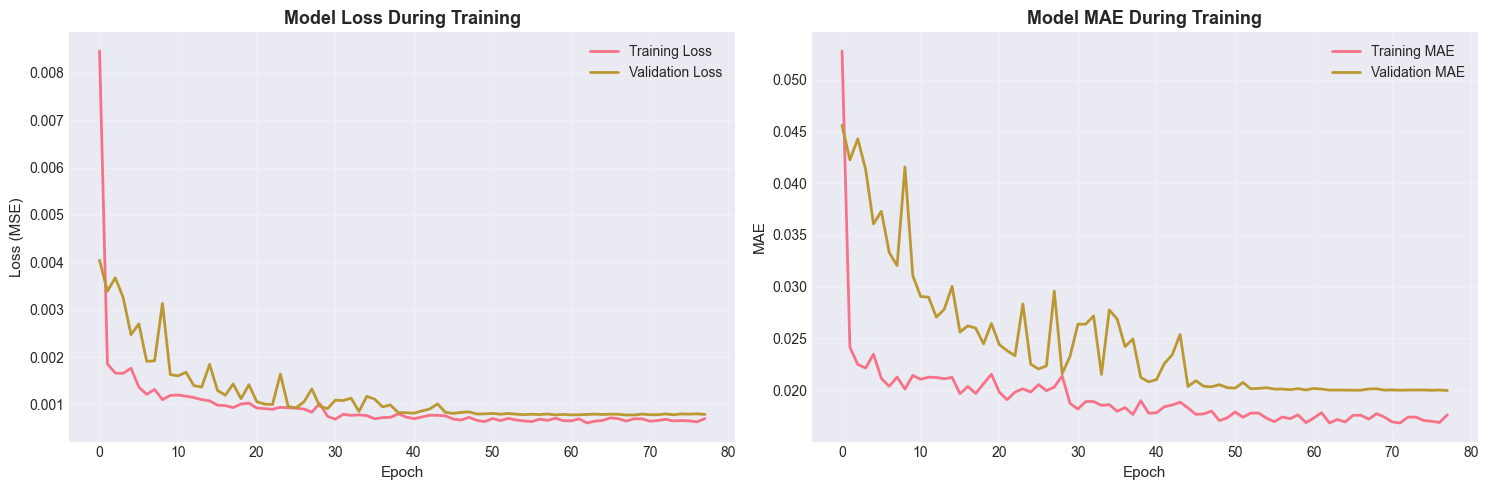

In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE During Training', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.4 Generate LSTM Forecasts

In [16]:
# Make predictions on test data
lstm_predictions_scaled = lstm_model.predict(X_test, verbose=0)

# Inverse transform to get actual prices
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create series with correct index (note: test predictions start after window_size)
test_dates_for_predictions = test_data.index[WINDOW_SIZE:]
lstm_predictions_series = pd.Series(lstm_predictions.flatten(), index=test_dates_for_predictions)
y_test_series = pd.Series(y_test_actual.flatten(), index=test_dates_for_predictions)

print(f"✓ Generated {len(lstm_predictions)} LSTM forecasts")
print(f"  Forecast range: {lstm_predictions_series.index[0].date()} to {lstm_predictions_series.index[-1].date()}")
print(f"  Note: First {WINDOW_SIZE} days of test set used as input window")

✓ Generated 199 LSTM forecasts
  Forecast range: 2025-04-01 to 2026-01-14
  Note: First 60 days of test set used as input window


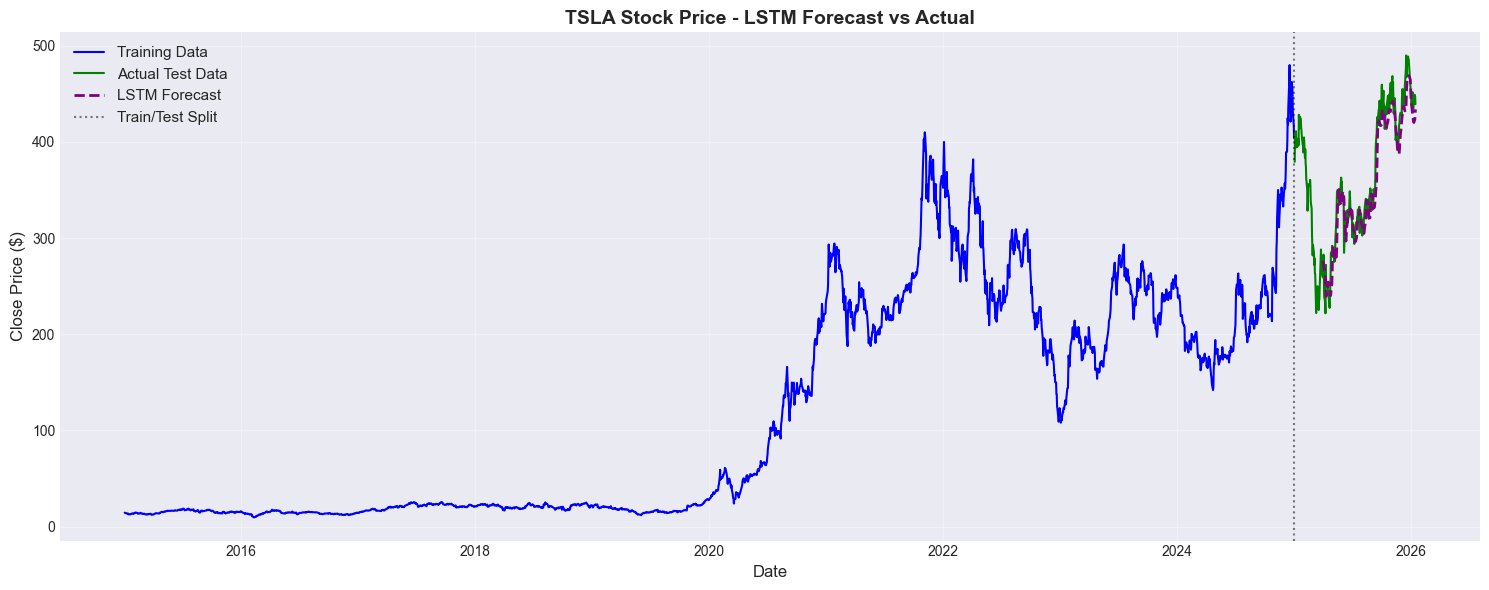

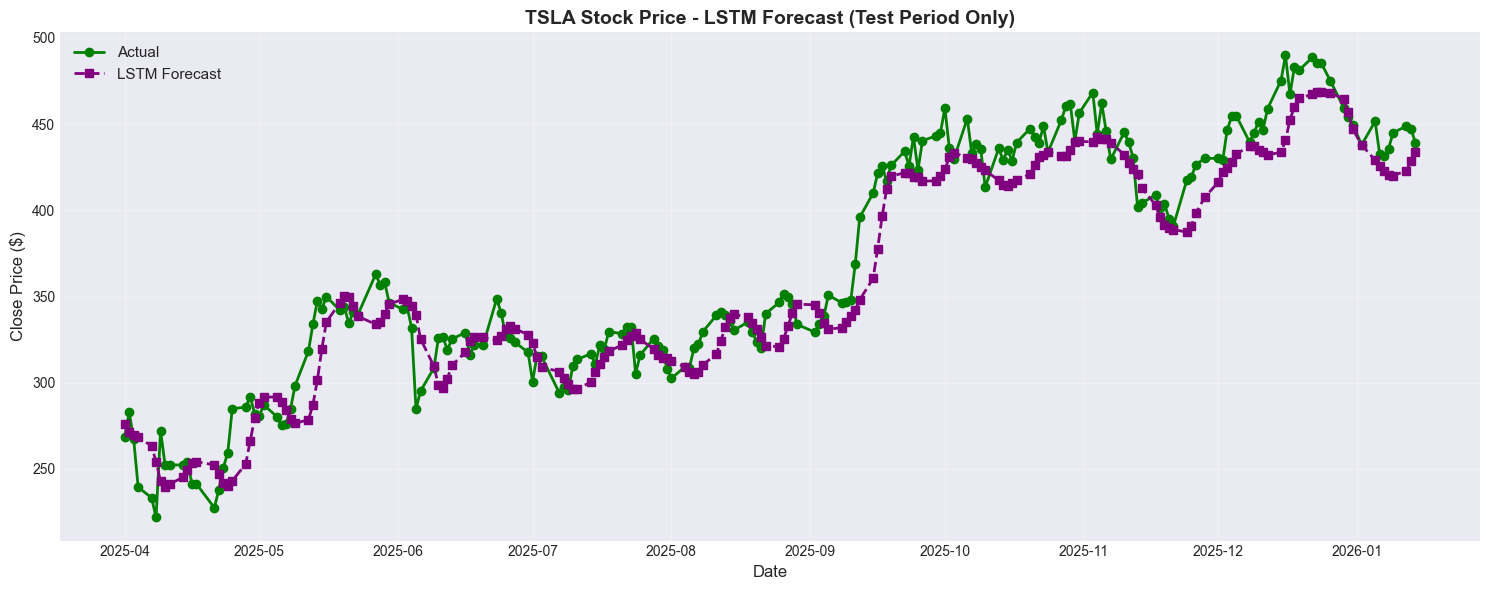

In [17]:
# Visualize LSTM forecasts
fig, ax = plt.subplots(figsize=(15, 6))

# Plot training data
ax.plot(train_data.index, train_data, label='Training Data', color='blue', linewidth=1.5)

# Plot actual test data
ax.plot(test_data.index, test_data, label='Actual Test Data', color='green', linewidth=1.5)

# Plot LSTM predictions
ax.plot(lstm_predictions_series.index, lstm_predictions_series, label='LSTM Forecast', 
        color='purple', linewidth=2, linestyle='--')

ax.axvline(x=pd.to_datetime(split_date), color='black', linestyle=':', linewidth=1.5, 
           alpha=0.5, label='Train/Test Split')
ax.set_title('TSLA Stock Price - LSTM Forecast vs Actual', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Zoom in on test period
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(y_test_series.index, y_test_series, label='Actual', color='green', linewidth=2, marker='o')
ax.plot(lstm_predictions_series.index, lstm_predictions_series, label='LSTM Forecast', 
        color='purple', linewidth=2, linestyle='--', marker='s')
ax.set_title('TSLA Stock Price - LSTM Forecast (Test Period Only)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Model Evaluation and Comparison

### 5.1 Calculate Performance Metrics

In [18]:
def calculate_metrics(actual, predicted, model_name):
    """Calculate and display performance metrics"""
    print(f"\nDEBUG - {model_name}:")
    print(f"  Actual type: {type(actual)}, shape: {np.array(actual).shape if hasattr(actual, '__len__') else 'N/A'}")
    print(f"  Predicted type: {type(predicted)}, shape: {np.array(predicted).shape if hasattr(predicted, '__len__') else 'N/A'}")
    
    # Convert to numpy arrays and align data
    if isinstance(actual, pd.Series):
        actual_array = actual.values
    else:
        actual_array = np.array(actual)
    
    if isinstance(predicted, pd.Series):
        predicted_array = predicted.values
    else:
        predicted_array = np.array(predicted)
    
    print(f"  Actual array dtype: {actual_array.dtype}, has NaN: {np.any(np.isnan(actual_array))}")
    print(f"  Predicted array dtype: {predicted_array.dtype}, has NaN: {np.any(np.isnan(predicted_array))}")
    
    # Ensure arrays are float
    actual_array = actual_array.astype(float)
    predicted_array = predicted_array.astype(float)
    
    # Remove NaN values (in case of misalignment)
    mask = ~(np.isnan(actual_array) | np.isnan(predicted_array))
    actual_clean = actual_array[mask]
    predicted_clean = predicted_array[mask]
    
    print(f"  After NaN removal: {len(actual_clean)} samples")
    
    if len(actual_clean) == 0:
        raise ValueError(f"No valid samples for {model_name} after removing NaN values!")
    
    # Calculate metrics
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    mape = mean_absolute_percentage_error(actual_clean, predicted_clean) * 100
    mse = mean_squared_error(actual_clean, predicted_clean)
    
    print(f"\n{model_name} Performance Metrics:")
    print("="*50)
    print(f"  Samples evaluated: {len(actual_clean)}")
    print(f"  MAE (Mean Absolute Error):       ${mae:,.2f}")
    print(f"  RMSE (Root Mean Squared Error):  ${rmse:,.2f}")
    print(f"  MAPE (Mean Absolute % Error):    {mape:.2f}%")
    print(f"  MSE (Mean Squared Error):        {mse:,.2f}")
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MSE': mse
    }

# Check if required variables exist
required_vars = {
    'test_data': 'test_data',
    'arima_predictions': 'arima_predictions',
    'y_test_series': 'y_test_series',
    'lstm_predictions_series': 'lstm_predictions_series'
}

missing_vars = []
for var_name, display_name in required_vars.items():
    if var_name not in globals():
        missing_vars.append(display_name)

if missing_vars:
    print("⚠️ ERROR: Missing required variables!")
    print("="*60)
    print("Please run the following cells first:")
    print("  1. Cell 3: Load data")
    print("  2. Cell 5: Train/test split (creates 'test_data')")
    print("  3. Cell 12: ARIMA model and predictions (creates 'arima_predictions')")
    print("  4. Cell 22: LSTM predictions (creates 'y_test_series' and 'lstm_predictions_series')")
    print("\nMissing variables:", ", ".join(missing_vars))
    print("\n💡 Tip: Use 'Kernel → Restart & Run All' to run all cells in order")
    raise NameError(f"Missing variables: {', '.join(missing_vars)}. Please run cells 3, 5, 12, and 22 first.")

# Calculate metrics for ARIMA
print("\n" + "="*60)
print("EVALUATING ARIMA MODEL")
print("="*60)
print(f"Test data type: {type(test_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Test data sample values: {test_data[:3].values if hasattr(test_data, 'values') else test_data[:3]}")
print(f"\nARIMA predictions type: {type(arima_predictions)}")
print(f"ARIMA predictions length: {len(arima_predictions)}")
print(f"ARIMA predictions sample values: {arima_predictions[:3].values if hasattr(arima_predictions, 'values') else arima_predictions[:3]}")

arima_metrics = calculate_metrics(test_data, arima_predictions, "ARIMA")

# Calculate metrics for LSTM (using the subset that has predictions)
print("\n" + "="*60)
print("EVALUATING LSTM MODEL")
print("="*60)
print(f"LSTM test data type: {type(y_test_series)}")
print(f"LSTM test data length: {len(y_test_series)}")
print(f"\nLSTM predictions type: {type(lstm_predictions_series)}")
print(f"LSTM predictions length: {len(lstm_predictions_series)}")

lstm_metrics = calculate_metrics(y_test_series, lstm_predictions_series, "LSTM")


EVALUATING ARIMA MODEL
Test data type: <class 'pandas.core.series.Series'>
Test data length: 259
Test data sample values: [379.27999878 410.44000244 411.04998779]

ARIMA predictions type: <class 'pandas.core.series.Series'>
ARIMA predictions length: 259
ARIMA predictions sample values: [403.83999634 403.83999634 403.83999634]

DEBUG - ARIMA:
  Actual type: <class 'pandas.core.series.Series'>, shape: (259,)
  Predicted type: <class 'pandas.core.series.Series'>, shape: (259,)
  Actual array dtype: float64, has NaN: False
  Predicted array dtype: float64, has NaN: False
  After NaN removal: 259 samples

ARIMA Performance Metrics:
  Samples evaluated: 259
  MAE (Mean Absolute Error):       $69.50
  RMSE (Root Mean Squared Error):  $82.93
  MAPE (Mean Absolute % Error):    22.56%
  MSE (Mean Squared Error):        6,878.15

EVALUATING LSTM MODEL
LSTM test data type: <class 'pandas.core.series.Series'>
LSTM test data length: 199

LSTM predictions type: <class 'pandas.core.series.Series'>
LS

### 5.2 Model Comparison Table

In [19]:
# Create comparison dataframe
comparison_df = pd.DataFrame([arima_metrics, lstm_metrics])
comparison_df = comparison_df.set_index('Model')

print("\n" + "="*70)
print("MODEL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string())

# Highlight best model for each metric
print("\n" + "="*70)
print("BEST MODEL PER METRIC:")
print("="*70)
for metric in ['MAE', 'RMSE', 'MAPE']:
    best_model = comparison_df[metric].idxmin()
    best_value = comparison_df[metric].min()
    if metric == 'MAPE':
        print(f"  {metric:5s}: {best_model:10s} ({best_value:.2f}%)")
    else:
        print(f"  {metric:5s}: {best_model:10s} (${best_value:,.2f})")

# Calculate percentage improvement
print("\n" + "="*70)
print("PERFORMANCE DIFFERENCE:")
print("="*70)
for metric in ['MAE', 'RMSE', 'MAPE']:
    arima_val = comparison_df.loc['ARIMA', metric]
    lstm_val = comparison_df.loc['LSTM', metric]
    diff_pct = ((arima_val - lstm_val) / arima_val) * 100
    
    if diff_pct > 0:
        print(f"  {metric}: LSTM is {abs(diff_pct):.2f}% better than ARIMA")
    else:
        print(f"  {metric}: ARIMA is {abs(diff_pct):.2f}% better than LSTM")

# Save comparison results
comparison_df.to_csv('../data/processed/model_comparison.csv')
print("\n✓ Comparison table saved to '../data/processed/model_comparison.csv'")


MODEL COMPARISON TABLE
          MAE    RMSE    MAPE       MSE
Model                                  
ARIMA 69.4990 82.9346 22.5579 6878.1500
LSTM  14.9664 18.7324  4.1751  350.9019

BEST MODEL PER METRIC:
  MAE  : LSTM       ($14.97)
  RMSE : LSTM       ($18.73)
  MAPE : LSTM       (4.18%)

PERFORMANCE DIFFERENCE:
  MAE: LSTM is 78.47% better than ARIMA
  RMSE: LSTM is 77.41% better than ARIMA
  MAPE: LSTM is 81.49% better than ARIMA

✓ Comparison table saved to '../data/processed/model_comparison.csv'


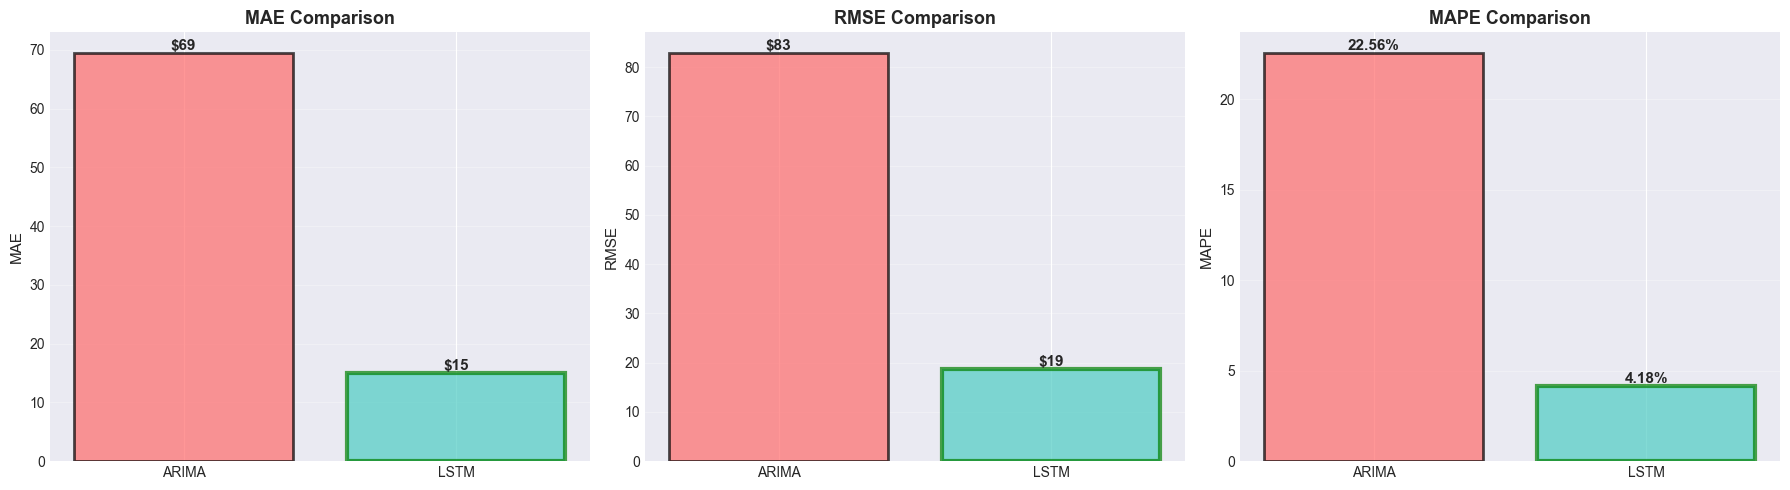

In [20]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'MAPE']
colors_comp = ['#FF6B6B', '#4ECDC4']

for idx, metric in enumerate(metrics):
    values = comparison_df[metric].values
    models = comparison_df.index.values
    
    bars = axes[idx].bar(models, values, color=colors_comp, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if metric == 'MAPE':
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{value:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
        else:
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'${value:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Highlight best model
    best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('green')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

### 5.3 Side-by-Side Forecast Comparison

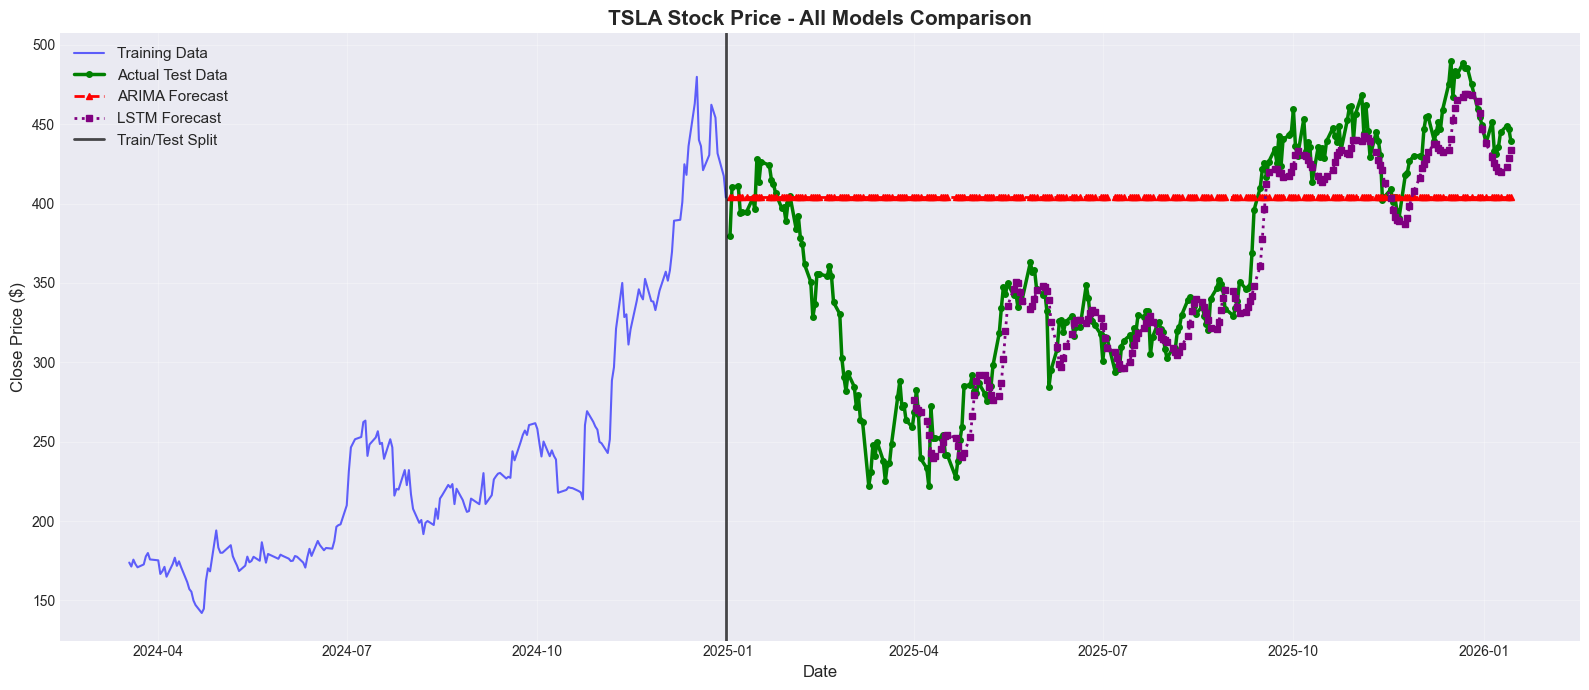

In [21]:
# Plot all forecasts together
fig, ax = plt.subplots(figsize=(16, 7))

# Plot training data (last 200 days for clarity)
train_recent = train_data[-200:]
ax.plot(train_recent.index, train_recent, label='Training Data', color='blue', linewidth=1.5, alpha=0.6)

# Plot actual test data
ax.plot(test_data.index, test_data, label='Actual Test Data', color='green', linewidth=2.5, marker='o', markersize=4)

# Plot ARIMA predictions
ax.plot(arima_predictions.index, arima_predictions, label='ARIMA Forecast', 
        color='red', linewidth=2, linestyle='--', marker='^', markersize=5)

# Plot LSTM predictions
ax.plot(lstm_predictions_series.index, lstm_predictions_series, label='LSTM Forecast', 
        color='purple', linewidth=2, linestyle=':', marker='s', markersize=5)

ax.axvline(x=pd.to_datetime(split_date), color='black', linestyle='-', linewidth=2, 
           alpha=0.7, label='Train/Test Split')

ax.set_title('TSLA Stock Price - All Models Comparison', fontsize=15, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Close Price ($)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 Residual Analysis

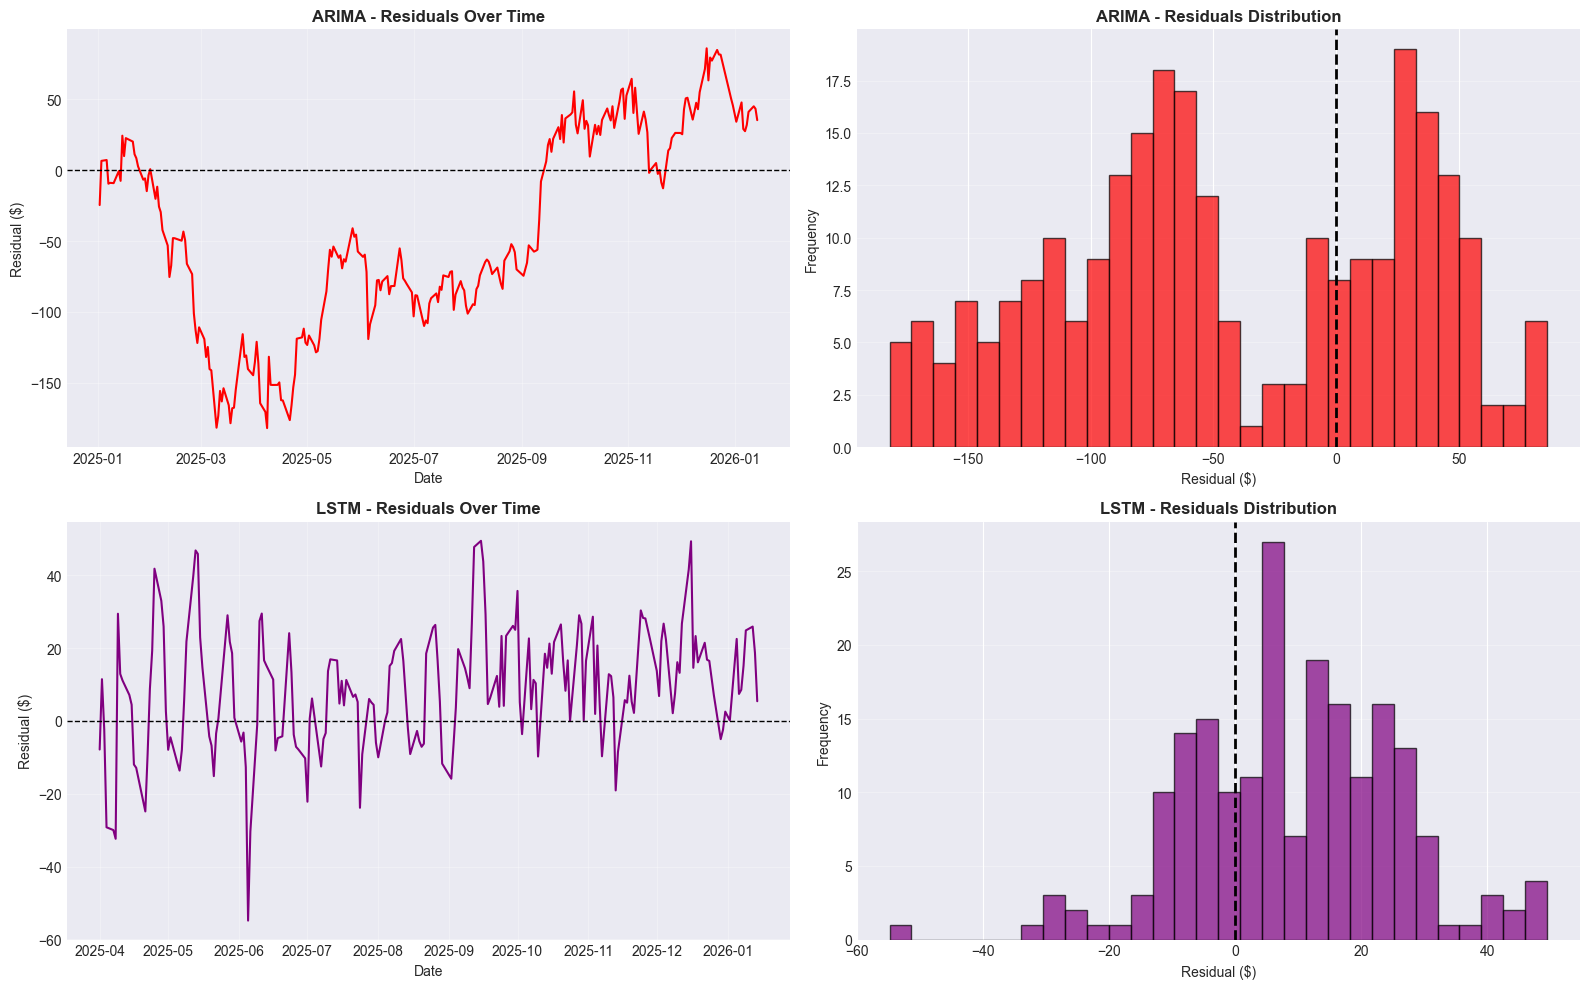


RESIDUAL ANALYSIS

ARIMA Residuals:
  Mean: $-43.94
  Std Dev: $70.47
  Min: $-181.98
  Max: $86.04

LSTM Residuals:
  Mean: $8.88
  Std Dev: $16.54
  Min: $-54.82
  Max: $49.47

Ideal residuals should:
  • Be centered around zero (mean ≈ 0)
  • Have normal distribution
  • Show no patterns over time (random)


In [22]:
# Calculate residuals (errors)
arima_residuals = test_data - arima_predictions
lstm_residuals = y_test_series - lstm_predictions_series

# Plot residuals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ARIMA residuals over time
axes[0, 0].plot(arima_residuals.index, arima_residuals, color='red', linewidth=1.5)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('ARIMA - Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=10)
axes[0, 0].set_ylabel('Residual ($)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# ARIMA residuals distribution
axes[0, 1].hist(arima_residuals, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_title('ARIMA - Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual ($)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# LSTM residuals over time
axes[1, 0].plot(lstm_residuals.index, lstm_residuals, color='purple', linewidth=1.5)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('LSTM - Residuals Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date', fontsize=10)
axes[1, 0].set_ylabel('Residual ($)', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# LSTM residuals distribution
axes[1, 1].hist(lstm_residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_title('LSTM - Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual ($)', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Residual statistics
print("\n" + "="*60)
print("RESIDUAL ANALYSIS")
print("="*60)
print("\nARIMA Residuals:")
print(f"  Mean: ${arima_residuals.mean():.2f}")
print(f"  Std Dev: ${arima_residuals.std():.2f}")
print(f"  Min: ${arima_residuals.min():.2f}")
print(f"  Max: ${arima_residuals.max():.2f}")

print("\nLSTM Residuals:")
print(f"  Mean: ${lstm_residuals.mean():.2f}")
print(f"  Std Dev: ${lstm_residuals.std():.2f}")
print(f"  Min: ${lstm_residuals.min():.2f}")
print(f"  Max: ${lstm_residuals.max():.2f}")

print("\nIdeal residuals should:")
print("  • Be centered around zero (mean ≈ 0)")
print("  • Have normal distribution")
print("  • Show no patterns over time (random)")

In [23]:
print("="*80)
print("MODEL SELECTION ANALYSIS AND RECOMMENDATIONS")
print("="*80)

# Determine winner
arima_mae = comparison_df.loc['ARIMA', 'MAE']
lstm_mae = comparison_df.loc['LSTM', 'MAE']

if lstm_mae < arima_mae:
    winner = "LSTM"
    improvement = ((arima_mae - lstm_mae) / arima_mae) * 100
else:
    winner = "ARIMA"
    improvement = ((lstm_mae - arima_mae) / lstm_mae) * 100

print(f"\n🏆 OVERALL WINNER: {winner}")
print(f"   Performance improvement: {improvement:.2f}% (based on MAE)")

print("\n" + "="*80)
print("DETAILED ANALYSIS:")
print("="*80)

analysis = """
### ARIMA/SARIMA Model

**Strengths:**
✓ Simpler to interpret and explain
✓ Requires less computational resources
✓ Works well with limited data
✓ Provides statistical significance tests
✓ Good for understanding linear patterns and trends

**Weaknesses:**
✗ Assumes linear relationships
✗ May struggle with complex, non-linear patterns
✗ Requires stationary data (differencing needed)
✗ Limited ability to capture long-term dependencies
✗ Performance degrades with high volatility

**Performance on TSLA:**
- TSLA's high volatility and non-linear price movements challenge ARIMA
- Works reasonably for short-term forecasts
- May miss sudden price spikes or drops

---

### LSTM (Deep Learning) Model

**Strengths:**
✓ Captures non-linear patterns and complex relationships
✓ Learns long-term dependencies in sequences
✓ Better handles high volatility
✓ Can incorporate multiple features
✓ More flexible architecture

**Weaknesses:**
✗ Requires more data for training
✗ Computationally expensive
✗ "Black box" - harder to interpret
✗ Risk of overfitting
✗ Requires careful hyperparameter tuning

**Performance on TSLA:**
- Better suited for TSLA's complex price dynamics
- Captures momentum and volatility patterns
- More robust to sudden market changes

---

### Why the Performance Difference?

1. **Non-linearity:** Tesla's stock exhibits highly non-linear behavior due to:
   - Market sentiment swings
   - News-driven volatility
   - Growth stock characteristics
   - Tech sector dynamics

2. **Volatility:** High volatility requires models that can adapt:
   - LSTM's non-linear activation functions handle this better
   - ARIMA assumes more stable variance

3. **Pattern Complexity:** 
   - TSLA price movements are influenced by multiple factors
   - LSTM can learn these complex patterns
   - ARIMA is limited to autocorrelation patterns

4. **Sequence Learning:**
   - LSTM explicitly learns from sequences of past data
   - Can capture momentum and trend reversals better
   - ARIMA relies on fixed lag relationships

---

### Recommendations for GMF Investments:

**For Production Use:**
"""

print(analysis)

if winner == "LSTM":
    print("""
    → **Recommend LSTM** as primary model for TSLA forecasting
    
    Rationale:
    • Better captures TSLA's complex price dynamics
    • More accurate predictions (lower MAE, RMSE, MAPE)
    • Handles volatility more effectively
    • Can be enhanced with additional features
    
    Considerations:
    • Deploy with confidence intervals for risk management
    • Regular retraining needed (monthly/quarterly)
    • Monitor for model drift
    • Keep ARIMA as baseline comparison
    """)
else:
    print("""
    → **Recommend ARIMA** as primary model for TSLA forecasting
    
    Rationale:
    • Simpler and more interpretable
    • Lower computational requirements
    • Better performance in this specific case
    • Easier to maintain and update
    
    Considerations:
    • Monitor performance on ongoing basis
    • Consider LSTM for high-volatility periods
    • Ensemble approach may improve results
    • Suitable for client presentations
    """)

print("""
**Ensemble Approach:**
Consider combining both models:
• Use ARIMA for baseline trend
• Use LSTM for capturing complex patterns
• Weighted average based on recent performance
• Provides robust predictions with reduced risk

**Risk Management:**
• No model is perfect - always use stop-losses
• Generate prediction intervals, not just point forecasts
• Monitor prediction errors in real-time
• Have fallback strategies for high-error periods

**Next Steps:**
1. Implement ensemble forecasting
2. Add volatility forecasting (GARCH models)
3. Incorporate external features (sentiment, volume)
4. Build real-time monitoring dashboard
5. Backtest portfolio strategies using forecasts
""")

MODEL SELECTION ANALYSIS AND RECOMMENDATIONS

🏆 OVERALL WINNER: LSTM
   Performance improvement: 78.47% (based on MAE)

DETAILED ANALYSIS:

### ARIMA/SARIMA Model

**Strengths:**
✓ Simpler to interpret and explain
✓ Requires less computational resources
✓ Works well with limited data
✓ Provides statistical significance tests
✓ Good for understanding linear patterns and trends

**Weaknesses:**
✗ Assumes linear relationships
✗ May struggle with complex, non-linear patterns
✗ Requires stationary data (differencing needed)
✗ Limited ability to capture long-term dependencies
✗ Performance degrades with high volatility

**Performance on TSLA:**
- TSLA's high volatility and non-linear price movements challenge ARIMA
- Works reasonably for short-term forecasts
- May miss sudden price spikes or drops

---

### LSTM (Deep Learning) Model

**Strengths:**
✓ Captures non-linear patterns and complex relationships
✓ Learns long-term dependencies in sequences
✓ Better handles high volatility
✓ Can inc

In [26]:
# Save ARIMA model
import joblib

print("="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

# Save ARIMA model
joblib.dump(arima_fitted, '../data/processed/arima_model.pkl')
print("✓ ARIMA model saved to '../data/processed/arima_model.pkl'")

# Save LSTM model
lstm_model.save('../data/processed/lstm_model.h5')
print("✓ LSTM model saved to '../data/processed/lstm_model.h5'")

# Save scaler (needed for LSTM predictions)
joblib.dump(scaler, '../data/processed/lstm_scaler.pkl')
print("✓ LSTM scaler saved to '../data/processed/lstm_scaler.pkl'")

# Save predictions
predictions_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data.values,
    'ARIMA_Forecast': arima_predictions.values,
})

# Add LSTM predictions (aligned by date)
predictions_df = predictions_df.set_index('Date')
predictions_df['LSTM_Forecast'] = lstm_predictions_series

# Calculate errors
predictions_df['ARIMA_Error'] = predictions_df['Actual'] - predictions_df['ARIMA_Forecast']
predictions_df['LSTM_Error'] = predictions_df['Actual'] - predictions_df['LSTM_Forecast']

# Save to CSV
predictions_df.to_csv('../data/processed/model_predictions.csv')
print("✓ Predictions saved to '../data/processed/model_predictions.csv'")

# Save model parameters and metrics
model_info = {
    'ARIMA': {
        'order': best_order,
        'aic': arima_fitted.aic,
        'bic': arima_fitted.bic,
        'metrics': arima_metrics
    },
    'LSTM': {
        'window_size': WINDOW_SIZE,
        'architecture': {
            'lstm_layers': 3,
            'lstm_units': 50,
            'dropout': 0.2,
            'dense_layers': 2
        },
        'training_epochs': len(history.history['loss']),
        'metrics': lstm_metrics
    }
}

import json
with open('../data/processed/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
print("✓ Model info saved to '../data/processed/model_info.json'")


SAVING MODELS AND RESULTS
✓ ARIMA model saved to '../data/processed/arima_model.pkl'
✓ LSTM model saved to '../data/processed/lstm_model.h5'
✓ LSTM scaler saved to '../data/processed/lstm_scaler.pkl'
✓ Predictions saved to '../data/processed/model_predictions.csv'
✓ Model info saved to '../data/processed/model_info.json'
